### **Predicting House Prices: Regression Problem**

In [1]:
#"regression": predicting a continuous value
#"classification": predicting a discrete label

**Boston-Housing-Price-data**

In [2]:
from keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

In [3]:
train_data.shape,test_data.shape

((404, 13), (102, 13))

## **Preparing Data**

In [11]:
import numpy as np

**mtd-1**

In [4]:
mean = np.mean(train_data,axis=0)
std = np.std(train_data,axis=0)

train_data -=mean
train_data/=std

test_data -=mean
test_data/=std


**mtd-2**

In [4]:
from sklearn.preprocessing import StandardScaler
Ss = StandardScaler()

In [5]:
Ss.fit(train_data)
train_data_new = Ss.transform(train_data)
test_data_new = Ss.transform(test_data)

**or**

In [ ]:
train_data_new = Ss.fit_transform(train_data)
test_data_new = Ss.transform(test_data)

## **Network Building**

In [6]:
from keras.models import Sequential
from keras.layers import Dense

In [7]:
def build_model():
  model = Sequential()
  model.add(Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1))

  model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])

  return model

In [8]:
#since, last layer is purely linear, the network is free to learn to predict values in any range.
#if we apply a sigmoid activation function to our last layer, the network could only learn to predict values between 0 and 1.

## **K-fold**

In [9]:
#when data available is very small then K-fold validation is a great way to reliably evaluate a model.

In [12]:
k = 4
n = train_data_new.shape[0]//k
train_scores = []
val_scores = []
test_scores = []

for i in range(k):
  print('processing fold %d'%i)

  test_data = train_data_new[i*n:(i+1)*n]
  test_tar = train_targets[i*n:(i+1)*n]

  partial_train_data = np.concatenate([train_data_new[:i*n],train_data_new[(i+1)*n:]],axis=0)
  partial_train_tar = np.concatenate([train_targets[:i*n],train_targets[(i+1)*n:]],axis=0)

  model = build_model()
  model.fit(partial_train_data,partial_train_tar,epochs=500,verbose=0,batch_size=1,validation_split=0.2)

  
  #training v/s validation
  train_abs_error = model.history.history['mae']
  val_abs_error = model.history.history['val_mae']

  train_scores.append(train_abs_error)
  val_scores.append(val_abs_error)
  
  #test
  mse,mae = model.evaluate(test_data,test_tar)
  test_scores.append(mae)

processing fold 0
4/4 [==============================] - 0s 4ms/step - loss: 11.4256 - mae: 2.4600
processing fold 1
4/4 [==============================] - 0s 4ms/step - loss: 17.4848 - mae: 2.9522
processing fold 2
4/4 [==============================] - 0s 3ms/step - loss: 19.0463 - mae: 3.0601
processing fold 3
4/4 [==============================] - 0s 3ms/step - loss: 12.8638 - mae: 2.5800


 **Overall MAE on test data**

In [16]:
print(np.mean(test_scores))

2.7630890607833862


**Train v/s validation**

In [13]:
len(train_scores),len(train_scores[0])

(4, 500)

In [14]:
avg_train_mae = np.mean(train_scores,axis=0)
avg_val_mae = np.mean(val_scores,axis=0)

Text(0, 0.5, 'validation MAE')

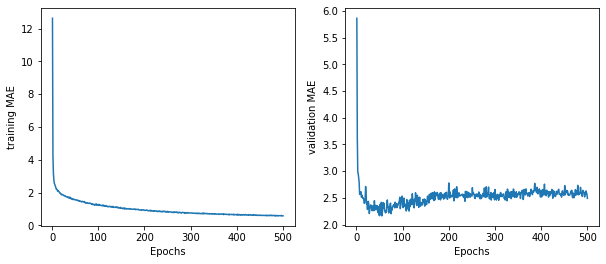

In [40]:
import matplotlib.pyplot as plt
epochs = range(1,len(train_scores[0])+1)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs,avg_train_mae)
plt.xlabel('Epochs')
plt.ylabel('training MAE')


plt.subplot(1,2,2)
plt.plot(epochs,avg_val_mae)
plt.xlabel('Epochs')
plt.ylabel('validation MAE')

In [ ]:
#Due to scaling issues and relatively high variance, its a bit hard to see the plot
#lets plot smooth curve

In [34]:
def smooth_curve(points,beta=0.9):    #beta =0.9 --->> avg over(1/(1-beta)) = 10 points
  exp_weighted_moving_avg_pts = []

  for current in points:
    if exp_weighted_moving_avg_pts:
      prev = exp_weighted_moving_avg_pts[-1]
      exp_weighted_moving_avg_pts.append(beta*prev + (1-beta)*current) #Exponentially moving weighted avg
    else:
      exp_weighted_moving_avg_pts.append(current)

                                          #since, beta=0.9  means we are considering avg of last 10 data pts
  return exp_weighted_moving_avg_pts[10:] #Hence, omitting the first 10 data pts which are on different scale from rest of the curve

In [35]:
smooth_MAE = smooth_curve(avg_val_mae)

Text(0, 0.5, 'validation MAE')

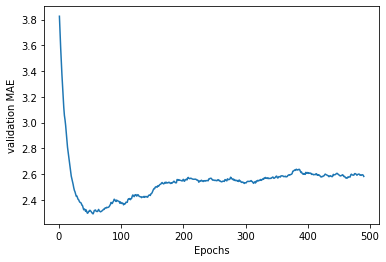

In [39]:
epochs = range(1,len(avg_val_mae)+1-10)
plt.plot(epochs,smooth_MAE)
plt.xlabel('Epochs')
plt.ylabel('validation MAE')

In [41]:
#According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

In [46]:
from keras import backend as k
k.clear_session()

In [45]:
model = build_model()
model.fit(train_data_new,train_targets,epochs=80,verbose=0,batch_size=16,validation_split=0.2)
test_mse_score,test_mae_score = model.evaluate(test_data_new,test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 24.0808 - mae: 3.1612


In [47]:
test_mae_score

3.1612040996551514